# Introduction

Airbnb is an online marketplace that connects people who want to rent out their homes with people who are looking for accomodations in specific locales.

According Airbnb in 2021, it has in excess of 5.6 million listing, covering more than 100,00 cities and town and 220-plus countries worldwide.

## About the dataset

The dataset is a kaggle dataset that contains a bunch of airbnb reviews, we have the columns: listing_id, id, date, reviews_id, reviewer_name and the comments. 

The only information used is the comment. For each comment, we've separated it using the dots in the review text and exploded a single review in multiple comments.

## Main Objective

The main objective is to get every comment and check which room are the most importants for a reviewer, so we built a wordcloud for each type of comment (negative or positive) and them verified every rooms that contains in the reviews.

So, the people who wants to announce in this website can pay attention in these rooms and choose improve it or not.

## Implementation Details

For treating the review messages we first lematize and tokenize the text utilizing functions from the nltk library. Than we stemmerize the words with Port Stemmer and after this we remove the stop words from this messages also with nltk.

After treating the reviews we make a sentiment analysis with the Text Blob library. The function from this library that we use gives a score from 0 to 1 for how positive or negative is a given sentence. So having this scores we separate the review messages in 5 groups and remove the group with a score close to 0.5, the neutral ones.

Having done this we simply have to generate the positive word cloud with the positve group of reviews and also the negative one. For this task we are using the wordcloud library.

# Install Dependencies

## Pip libraries

In [ ]:
!pip install langdetect
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

## Libraries

In [ ]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from langdetect import detect, LangDetectException
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from typing import List
import matplotlib.pyplot as plt
from collections import Counter
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet as wn
from collections import OrderedDict

## Initialize tqdm

In [ ]:
tqdm.pandas()

## NLTK Imports

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## WordCloud Stop Words

In [ ]:
stopwords = set(STOPWORDS)

## Download Kaggle Dataset

In [ ]:
!wget -O kaggle.json https://cdn.discordapp.com/attachments/539836343094870016/982071536087351416/kaggle_1.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d samyukthamurali/airbnb-ratings-dataset
!unzip airbnb-ratings-dataset.zip

--2022-06-18 17:31:57--  https://cdn.discordapp.com/attachments/539836343094870016/982071536087351416/kaggle_1.json
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.133.233, 162.159.130.233, 162.159.129.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.133.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [application/json]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2022-06-18 17:31:57 (11.7 MB/s) - ‘kaggle.json’ saved [63/63]

mkdir: cannot create directory ‘/root/.kaggle’: File exists
airbnb-ratings-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  airbnb-ratings-dataset.zip
replace LA_Listings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Functions

## safe_detect_language(text: str)

In [ ]:
def safe_detect_language(text: str) -> str:
  """ Check the language detection 

  Args:
      text (str): Text to treat
      
  Returns:
      str: The language of the text
  """
  try:
    return detect(text)
  except LangDetectException: #catches non string values
    return 'err'

## replace_multiple_spaces_by_one(text: str)

In [ ]:
def replace_multiple_spaces_by_one(text: str) -> str:
  """Replace multiple space by one regex

  Args:
      text (str): Text to replace multiple space by one regex
      
  Returns:
      str: Text without multiple space
  """
  text = re.sub(r"\s+", " ", text)
  return text  

## tokenize_text(text: str)

In [ ]:
def tokenize_text(text: str) -> str:
  """Tokenize text

  Args:
    text (str): Text to be tokenized
  
  Returns:
      str: text with words tokenized
  """
  return ' '.join(nltk.word_tokenize(text))

## remove_stop_words(text: str)

In [ ]:
def remove_stop_words(text: str) -> str:
  """Remove stop words from text

  Args:
    text (str): text to remove the stop words
  
  Returns:
      str: text without stop words
  """
  stop_words = [word for word in nltk.corpus.stopwords.words("english")]
  return ' '.join(
      [word for word in text.split(' ')
       if word not in stop_words]
  )

## lemmatize_text(text: str)

In [ ]:
def lemmatize_text(text: str) -> str:
  """ Lemmatize a text

  Args:
    text (str): Text to be lemmatized
  
  Returns:
    str: Text lemmatized
  """
  return WordNetLemmatizer().lemmatize(text, pos='v')

## normalize(text: str)

In [ ]:
def normalize(text: str) -> str:
  """Normalizes the text

  Args:
    text (str): Text to be normalized

  Returns:
    str: Text normalized
  """
  text = ' '.join(simple_preprocess(text, deacc=True, min_len=3))
  text = replace_multiple_spaces_by_one(text)
  text = lemmatize_text(text)
  text = remove_stop_words(text)
  text = tokenize_text(text)
  return text

## steam(text: str)

In [ ]:
def steam(text: str) -> str:
  """Steam the words from a review

  Args:
    text (str): Text to be stemmed
  
  Returns:
    str: Stemmed text
  """
  stemmer = PorterStemmer()
  words = nltk.word_tokenize(text)
  newwords = [stemmer.stem(word) for word in words]
  text = ' '.join(newwords)
  return text.lower()

## get_sentiment(text: str)

In [ ]:
def get_sentiment(text: str) -> str:
  """Returns the sentiment of the text

  Args:
    text (str): The text to be calculated the sentiment
  
  Returns:
    str: The sentiment
  """
  blob = TextBlob(text)
  sentiment_polarity = round(blob.sentiment[0], 2)
  for key, value in SENTIMENTS.items():
    if any(np.isclose([sentiment_polarity], value)): # Checks if theres any value in the dictionary value near to the sentiment_polarity
      return key

## filter_room_words(text: str)

In [ ]:
def filter_room_words(text: str) -> List[str]:
  """ Given a text, check which room is in that text

  Args:
    text (str): The text to check the room
  
  Returns:
    List[str]: Every room found in that text
  """
  return [word for word in text.split(' ') if word in ROOMS]

## get_synonyms(list_of_words: List[str])

In [ ]:
def get_synonyms(list_of_words: List[str]) -> List[str]:
  """ Given a list of words, get its synonyms

  Args:
    list_of_words (List[str]): The list of words
  
  Returns:
    List[str]: The words and their synonyms
  """
  synonyms = []
  for word in list_of_words:
    for syn in wn.synsets(word):
      for lemma in syn.lemmas():
        synonyms.append(lemma.name().lower())
  return list(set(synonyms).union(set(list_of_words)))

## get_pos_tags_noun(list_of_words: List[str])

In [ ]:
def get_pos_tags_noun(list_of_words: List[str]) -> List[str]:
  nouns = []
  for word in list_of_words:
    if word[1] == 'NN':
      nouns.append(word[0])
  return word

## semantic_filter(list_of_words: List[str], synset: str, proximity: float)

In [ ]:
def semantic_filter(list_of_words: str, synset: str='room.n.01', proximity: float=0.1) -> List[str]:
  filtered_list = []
  text = nltk.tokenize.word_tokenize(list_of_words)
  postags = nltk.pos_tag(text)
  postags = get_pos_tags_noun(postags)
  for word in list_of_words.split(' '):
    for syn in wn.synsets(word):
      similarity = wn.synset(synset).path_similarity(syn)
      if similarity != None and similarity > proximity:
        if word in NOUNS and word in postags:
          filtered_list.append(word)
          break
  return filtered_list

# Constants

## NOUNS

In [ ]:
NOUNS = {x.name().split('.', 1)[0] for x in wn.all_synsets(wn.NOUN)}

## NUMBER_OF_REVIEWS

In [ ]:
NUMBER_OF_REVIEWS = 50000

## SENTIMENTS

In [ ]:
SENTIMENTS = {
    'horrible': np.arange(-1.0, -0.75, 0.01),
    'very negative': np.arange(-0.75, -0.5, 0.01),
    'negative': np.arange(-0.5, 0, 0.01),
    'neutral': [0],
    'positive': np.arange(0.01, 0.5, 0.01),
    'very positive': np.arange(0.5, 0.75, 0.01),
    'amazing': np.arange(0.75, 1.01, 0.01)
}

## ROOMS

In [ ]:
ROOMS = [
  'entrance hall',
  'foyer',
  'kitchen',
  'keeping room',
  'pantry',
  'dining room',
  'living room',
  'formal parlor',
  'reception room',
  'family room',
  'den',
  'sunroom',
  'home office',
  'library',
  'bathroom',
  'powder room',
  'half-bath',
  'laundry room',
  'broom',
  'linen closets',
  'storage room',
  'master bedroom',
  'walk-in closet',
  "kids' bedroom",
  'nursery',
  'guest room',
  'playroom',
  'game room',
  'music room',
  'home theater room',
  'home gym',
  'garage',
  'basement',
  'wine cellar',
  'root cellar',
  'attic',
  'loft',
  'garage',
  'bedroom',
  'balcony',
  'hall',
  'desk',
  'stair',
  'lobby',
  'roof',
  'terrace',
  'ground floor',
  'pool',
  'yard',
]

ROOMS = get_synonyms(ROOMS)

## POSITIVES

In [ ]:
POSITIVES = ['amazing', 'very positive', 'positive']

## NEGATIVES

In [ ]:
NEGATIVES = ['horrible', 'very negative', 'negative']

# Load Reviews Dataframe

In [ ]:
airbnb_reviews_dataframe = pd.read_csv("airbnb-reviews.csv", encoding='iso-8859-1', low_memory=False, sep=';').dropna()

In [ ]:
airbnb_reviews_dataframe.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

## Filter the number of reviews

In [ ]:
airbnb_reviews_filtered_dataframe = airbnb_reviews_dataframe.iloc[:NUMBER_OF_REVIEWS] #Get just the first N comments

# Treat Reviews messages

## Filter dataframe for only english comments

In [ ]:
airbnb_reviews_filtered_dataframe['language'] = airbnb_reviews_filtered_dataframe['comments'].progress_map(safe_detect_language)

100%|██████████| 50000/50000 [05:28<00:00, 152.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
english_airbnb_reviews_df = airbnb_reviews_filtered_dataframe[airbnb_reviews_filtered_dataframe['language'] == 'en'] #Filter for only english comments

## Explode Comments by sentences

In [ ]:
english_airbnb_reviews_df = english_airbnb_reviews_df.assign(comments=english_airbnb_reviews_df.comments.str.split(".")).explode('comments') #Split the comments by sentences

## Normalize Special Characters

In [ ]:
english_airbnb_reviews_df['treated_comments'] = english_airbnb_reviews_df['comments'].progress_map(normalize)

100%|██████████| 182647/182647 [01:10<00:00, 2601.94it/s]


In [ ]:
english_airbnb_reviews_df = english_airbnb_reviews_df[english_airbnb_reviews_df['treated_comments'] != '']

## Run Porter Stemmer

In [ ]:
english_airbnb_reviews_df['stemmed_comments'] = english_airbnb_reviews_df['treated_comments'].progress_map(steam)

100%|██████████| 158181/158181 [00:54<00:00, 2896.42it/s]


## Filter comment words

In [ ]:
# english_airbnb_reviews_df['filtered_comments'] = english_airbnb_reviews_df['stemmed_comments'].progress_map(semantic_filter)

## Add Rooms column

In [ ]:
english_airbnb_reviews_df['rooms'] = english_airbnb_reviews_df['stemmed_comments'].progress_map(filter_room_words)

100%|██████████| 158181/158181 [00:03<00:00, 46917.30it/s]


In [ ]:
english_airbnb_reviews_df = english_airbnb_reviews_df.explode('rooms').dropna()

# Sentiment Analysis

In [ ]:
english_airbnb_reviews_df['sentiment'] = english_airbnb_reviews_df['comments'].progress_map(get_sentiment)

100%|██████████| 11459/11459 [00:07<00:00, 1563.86it/s]


## Remove Neutral Sentiments

In [ ]:
english_airbnb_reviews_df = english_airbnb_reviews_df[english_airbnb_reviews_df['sentiment'] != 'neutral']

## Positive Sentiments

In [ ]:
positive_reviews_df = english_airbnb_reviews_df[english_airbnb_reviews_df['sentiment'].isin(POSITIVES)] 

In [ ]:
positive_reviews_df.shape[0] #Number of rows

8011

## Negative Sentiments

In [ ]:
negative_reviews_df = english_airbnb_reviews_df[english_airbnb_reviews_df['sentiment'].isin(NEGATIVES)] 

In [ ]:
negative_reviews_df.shape[0] #Number of rows

1793

# Word Cloud

## Positive Sentences

In [ ]:
positive_words_frequency = dict(positive_reviews_df['rooms'].value_counts())

In [ ]:
positive_wordcloud = WordCloud(stopwords=stopwords).generate_from_frequencies(positive_words_frequency)

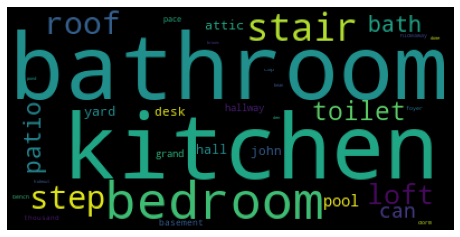

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.show()

## Negative Sentences

In [ ]:
negative_words_frequency = dict(negative_reviews_df['rooms'].value_counts())

In [ ]:
OrderedDict(negative_words_frequency)

OrderedDict([('bathroom', 510),
             ('kitchen', 256),
             ('stair', 242),
             ('bedroom', 240),
             ('toilet', 220),
             ('step', 110),
             ('bath', 44),
             ('can', 32),
             ('hall', 28),
             ('roof', 19),
             ('hallway', 19),
             ('patio', 17),
             ('loft', 14),
             ('basement', 11),
             ('yard', 7),
             ('attic', 6),
             ('pool', 5),
             ('desk', 3),
             ('foyer', 3),
             ('dorm', 2),
             ('grand', 1),
             ('thousand', 1),
             ('broom', 1),
             ('pond', 1),
             ('john', 1)])

In [ ]:
OrderedDict(positive_words_frequency)

OrderedDict([('bathroom', 2066),
             ('kitchen', 1998),
             ('bedroom', 1104),
             ('stair', 537),
             ('step', 384),
             ('roof', 359),
             ('loft', 283),
             ('toilet', 241),
             ('patio', 198),
             ('bath', 185),
             ('can', 153),
             ('pool', 85),
             ('attic', 55),
             ('hall', 51),
             ('yard', 49),
             ('john', 43),
             ('desk', 43),
             ('hallway', 31),
             ('grand', 28),
             ('basement', 22),
             ('pace', 18),
             ('thousand', 12),
             ('bench', 8),
             ('dorm', 7),
             ('hideaway', 6),
             ('cap', 6),
             ('foyer', 5),
             ('bean', 4),
             ('den', 4),
             ('broom', 4),
             ('pond', 3),
             ('hideout', 3),
             ('dome', 3),
             ('cellar', 2),
             ('garret', 2),
             ('m

In [ ]:
negative_wordcloud = WordCloud(stopwords=stopwords).generate_from_frequencies(negative_words_frequency)

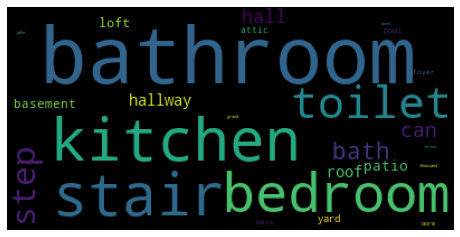

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.show()